In [62]:
using Sundials, ForwardDiff

import Sundials: realtype, N_Vector

type UserData
    f::Function
    p::Vector{Float64}
    D!::Function
end

function unzip(userdata_ptr::Ptr{Void})
    ud = unsafe_pointer_to_objref(userdata_ptr) :: UserData
    (ud.f, ud.p, ud.D!)
end

function cvodesfun(t, y, dy, userdata_ptr)
    y   = Sundials.asarray(y)
    dy  = Sundials.asarray(dy)
    f,p,D! = unzip(userdata_ptr)
    f(t, y, p, dy)
    return Int32(0)
end

function differentiator(f,ny,np)
    y  = Vector(ny)
    p  = Vector(np)
    dy = Vector(ny)
    J  = Matrix{Float64}(ny, ny+np)
    function merged(x)
        y[:]=x[1:ny]
        p[:]=x[ny+(1:np)]
        f(0,y,p,dy) # TODO fix time dependence
        dy
    end
    j! = ForwardDiff.jacobian(merged, mutates=true)
    (y0,p) -> j!(J, vcat(y0,p))
end

NVecVec = Ptr{N_Vector}

function sensrhsfn(ns::Int32, t::realtype, y::N_Vector, ydot::N_Vector, yS::NVecVec, ySdot::NVecVec, user_data::Ptr{Void}, tmp1::N_Vector, tmp2::N_Vector)
    np = ns
    
    f, p, D! = unzip(user_data)
    y     = Sundials.asarray(y)    
    yS    = pointer_to_array(yS, np)
    ySdot = pointer_to_array(ySdot, np)
    
    J = D!(y, p)    
    
    ny = size(J,1)
    
    for i in 1:np
      ySi      = Sundials.asarray(yS[i])
      ySdot[i] = Sundials.nvector(J[:,1:ny] * ySi + J[:,ny+i])
    end
    return Int32(0)
  end

# expect function signature f=f!(t, y0, p, dy)

function cvodes(f::Function, y0::Vector{Float64}, p::Vector{Float64}, ts::Vector{Float64};
    reltol=1e-8, abstol=1e-6, autodiff=true, stiff=true)
  ny   = length(y0)
  np   = length(p)

  ### Initialize automatic differentiator

  D! = autodiff ? differentiator(f, ny, np) : ()->()

  ### CVode settings ###
    
  cvode_mem = stiff ? 
    Sundials.CVodeCreate(Sundials.CV_BDF,   Sundials.CV_NEWTON) :
    Sundials.CVodeCreate(Sundials.CV_ADAMS, Sundials.CV_FUNCTIONAL)
  Sundials.CVodeInit(cvode_mem, cvodesfun, ts[1], y0)
  Sundials.CVodeSetUserData(cvode_mem, UserData(f,p,D!))
  Sundials.CVodeSStolerances(cvode_mem, reltol, abstol)
  #Sundials.CVDense(cvode_mem, ny)
  Sundials.CVDiag(cvode_mem)
  
  ### Sensiviy Settings ###
  
  yS = [Sundials.nvector(zeros(Float64, ny)) for i in 1:np] |> pointer
    
  if autodiff
    sensrhsfnptr = cfunction(sensrhsfn, Int32, (Int32, realtype, N_Vector, N_Vector, NVecVec, NVecVec, Ptr{Void}, N_Vector, N_Vector))
    Sundials.CVodeSensInit(cvode_mem, np, Sundials.CV_SIMULTANEOUS, sensrhsfnptr, yS)
  else
    Sundials.CVodeSensInit(cvode_mem, np, Sundials.CV_SIMULTANEOUS, Ptr{Void}(0), yS)
    Sundials.CVodeSetSensDQMethod(cvode_mem, Sundials.CV_CENTERED, 0.0) 
  end

  #Sundials.CVodeSetSensParams(cvode_mem, p, p, Ptr{Int32}(0))
  Sundials.CVodeSetSensErrCon(cvode_mem, 1)
  Sundials.CVodeSensEEtolerances(cvode_mem)

  #Sundials.CVodeSensSStolerances(cvode_mem, 1e-5, ones(np) * 1e-5) #p*1e-5)

  # Placeholder for solution and sensitivities
  solution = zeros(length(ts), ny)
  solution[1,:] = copy(y0)
  sens = zeros(length(ts),ny,np) # No need to copy initial condition, they are already zero

  tout = [0.] # output time reached by the solver
  yout = copy(y0)

  # Loop through all the output times
  for k in 2:length(ts)
    # Extract the solution to x, and the sensitivities to yS
    Sundials.CVode(cvode_mem, ts[k], yout, tout, Sundials.CV_NORMAL)
    Sundials.CVodeGetSens(cvode_mem, tout, yS)

    #Save the results
    solution[k,:] = yout
    for i in 1:np
      sens[k,:,i] = Sundials.asarray(unsafe_load(yS,i))
    end
  end

  return (solution,sens)
end

cvodes (generic function with 1 method)

In [63]:
function f(t,y,p,dy)
    dy[1] = p[1]
    dy[2] = p[2] * y[1]
end

@time cvodes(f, [-20., 0], [2., 1], collect(linspace(0,100,11)), autodiff = true)

(
11x2 Array{Float64,2}:
 -20.0             0.0       
  -5.32907e-15  -100.0       
  20.0             9.30369e-7
  40.0           300.0       
  60.0           800.0       
  80.0          1500.0       
 100.0          2400.0       
 120.0          3500.0       
 140.0          4800.0       
 160.0          6300.0       
 180.0          8000.0       ,

11x2x2 Array{Float64,3}:
[:, :, 1] =
   0.0     0.0
  10.0    50.0
  20.0   200.0
  30.0   450.0
  40.0   800.0
  50.0  1250.0
  60.0  1800.0
  70.0  2450.0
  80.0  3200.0
  90.0  4050.0
 100.0  5000.0

[:, :, 2] =
 0.0     0.0       
 0.0  -100.0       
 0.0     9.30369e-7
 0.0   300.0       
 0.0   800.0       
 0.0  1500.0       
 0.0  2400.0       
 0.0  3500.0       
 0.0  4800.0       
 0.0  6300.0       
 0.0  8000.0       )

0.371945 seconds (200.73 k allocations: 8.674 MB, 2.40% gc time)


In [59]:
using GynC
include("../src/gyncycle.jl")

t = collect(linspace(0,30,31))
p = copy(GynC.refallparms)
y0 = copy(GynC.refy0)

dy = Array(Float64,33)
D! = differentiator((t, y, p, dy) -> gyncycle_rhs!(y, p, dy), 33, 114);

In [60]:
macro prof(n,ex)
    quote
        $ex
        Profile.clear()
        @profile for i in 1:$n 
            $ex 
        end
        Profile.print()
    end
end

In [19]:
@prof 100_000 gyncycle_rhs!(y0,p,dy)

457 task.jl; anonymous; line: 447
 457 .../IJulia/src/IJulia.jl; eventloop; line: 141
  457 ...rc/execute_request.jl; execute_request_0x535c5df2; line: 177
   457 loading.jl; include_string; line: 266
    457 In[18]; anonymous; line: 6
     1  ...v/gc/src/gyncycle.jl; gyncycle_rhs!; line: 15
     18 ...v/gc/src/gyncycle.jl; gyncycle_rhs!; line: 54
     25 ...v/gc/src/gyncycle.jl; gyncycle_rhs!; line: 58
     27 ...v/gc/src/gyncycle.jl; gyncycle_rhs!; line: 59
     34 ...v/gc/src/gyncycle.jl; gyncycle_rhs!; line: 75
     25 ...v/gc/src/gyncycle.jl; gyncycle_rhs!; line: 76
     42 ...v/gc/src/gyncycle.jl; gyncycle_rhs!; line: 92
     19 ...v/gc/src/gyncycle.jl; gyncycle_rhs!; line: 95
     9  ...v/gc/src/gyncycle.jl; gyncycle_rhs!; line: 98
     35 ...v/gc/src/gyncycle.jl; gyncycle_rhs!; line: 101
     11 ...v/gc/src/gyncycle.jl; gyncycle_rhs!; line: 106
     7  ...v/gc/src/gyncycle.jl; gyncycle_rhs!; line: 111
     41 ...v/gc/src/gyncycle.jl; gyncycle_rhs!; line: 115
     30 ...v/gc/src

In [51]:
@prof 1000 D!(y0,p)

640 task.jl; anonymous; line: 447
 640 .../IJulia/src/IJulia.jl; eventloop; line: 141
  640 ...rc/execute_request.jl; execute_request_0x535c5df2; line: 177
   640 loading.jl; include_string; line: 266
    640 In[20]; anonymous; line: 6
     640 In[1]; anonymous; line: 36
      635 ...src/api/jacobian.jl; j!; line: 62
       138 ...orwardDiffResult.jl; jacobian!; line: 83
        138 ...orwardDiffResult.jl; get_jacobian!; line: 99
         129 ...orwardDiffResult.jl; _load_jacobian!; line: 90
         2   simdloop.jl; _load_jacobian!; line: 74
         3   simdloop.jl; _load_jacobian!; line: 75
         4   simdloop.jl; _load_jacobian!; line: 84
       6   ...src/api/jacobian.jl; _calc_jacobian; line: 98
       463 ...src/api/jacobian.jl; _calc_jacobian; line: 101
        2   In[1]; merged; line: 30
         1 array.jl; getindex; line: 288
          1 array.jl; unsafe_getindex; line: 295
         1 multidimensional.jl; _unsafe_batchsetindex!; line: 329
        5   In[1]; merged; line: 3

In [ ]:
@time sol_cvodes, sens = cvodes((t, y, p, dy) -> gyncycle_rhs!(y, p, dy), y0, p, t, autodiff=true, stiff=true)
sens[:,33,114]

In [65]:
@prof 100 Sundials.cvode((t, y, dy) -> gyncycle_rhs!(y, p, dy), y0, t)

58  ...ndials/src/Sundials.jl; cvodefun; line: 270
16  ...ndials/src/Sundials.jl; cvodefun; line: 271
291 ...ndials/src/Sundials.jl; cvodefun; line: 272
 287 In[65]; anonymous; line: 1
  13 ...ev/gc/src/gyncycle.jl; gyncycle_rhs!; line: 54
  1  ...ev/gc/src/gyncycle.jl; gyncycle_rhs!; line: 55
  21 ...ev/gc/src/gyncycle.jl; gyncycle_rhs!; line: 58
  9  ...ev/gc/src/gyncycle.jl; gyncycle_rhs!; line: 59
  2  ...ev/gc/src/gyncycle.jl; gyncycle_rhs!; line: 60
  1  ...ev/gc/src/gyncycle.jl; gyncycle_rhs!; line: 69
  25 ...ev/gc/src/gyncycle.jl; gyncycle_rhs!; line: 75
  24 ...ev/gc/src/gyncycle.jl; gyncycle_rhs!; line: 76
  26 ...ev/gc/src/gyncycle.jl; gyncycle_rhs!; line: 92
  25 ...ev/gc/src/gyncycle.jl; gyncycle_rhs!; line: 95
  18 ...ev/gc/src/gyncycle.jl; gyncycle_rhs!; line: 98
  11 ...ev/gc/src/gyncycle.jl; gyncycle_rhs!; line: 101
  7  ...ev/gc/src/gyncycle.jl; gyncycle_rhs!; line: 106
  9  ...ev/gc/src/gyncycle.jl; gyncycle_rhs!; line: 111
  16 ...ev/gc/src/gyncycle.jl; gyncycle_rh

In [69]:
# sundials vs limex
@time sol_cvode = Sundials.cvode((t, y, dy) -> gyncycle_rhs!(y, p, dy), y0, t) #, reltol = 1e-2, abstol=1e-2)
@time sol_limex = GynC.gync(y0, t, p);

  0.011004 seconds (6.42 k allocations: 196.055 KB)
  0.041309 seconds (6 allocations: 8.625 KB)


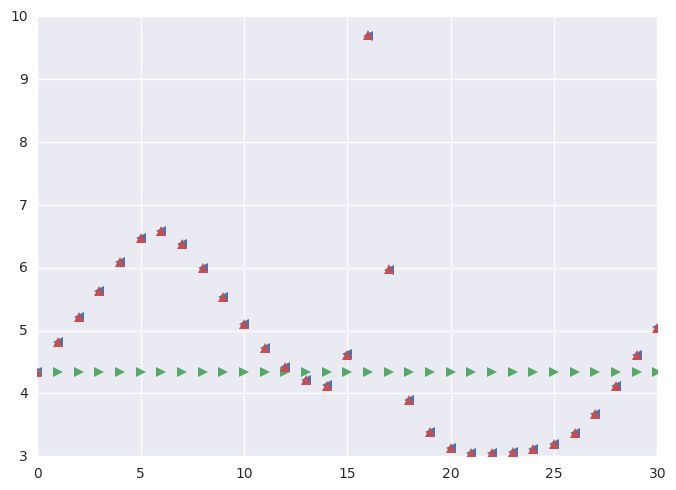

3-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f966af0c510>
 PyObject <matplotlib.lines.Line2D object at 0x7f966aedca90>
 PyObject <matplotlib.lines.Line2D object at 0x7f966ac64b10>

In [70]:
# compare solutions
using PyPlot
plot(t, sol_cvode[:,7], "<", t, sol_cvodes[:,7], ">", t, sol_limex[7,:] |> vec, "^", )